# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Tue Dec 26 18:02:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

# Import libraries

In [2]:
!pip install split-folders
!pip install optuna

In [3]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Description of the data set

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.


# Data Preprcessing

In [4]:
data_dir = '/kaggle/input/garbage-classification-v2/'

Cleaning the working directory if there are any files in it

In [5]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [6]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

'/kaggle/working/dataset'

In [7]:
data_dir  = '/kaggle/working/dataset'

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [8]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/plastic/plastic_553.jpg is not an image
/kaggle/working/dataset/plastic/plastic_553.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2038.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2038.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_1260.jpg is not an image
/kaggle/working/dataset/plastic/plastic_1260.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_415.jpg is not an image
/kaggle/working/dataset/plastic/plastic_415.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2094.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2094.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_1494.jpg is not an image
/kaggle/working/dataset/plastic/plastic_1494.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_1486.jpg is not an image
/kaggle/working/dataset/pla

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [9]:
os.mkdir('data')

In [10]:
os.chdir('data')

In [11]:
os.getcwd()

'/kaggle/working/data'

In [12]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [13]:
os.chdir('/kaggle/working/')

In [14]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [15]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [16]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 23584 files [00:03, 6258.72 files/s]


In [17]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [18]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [19]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

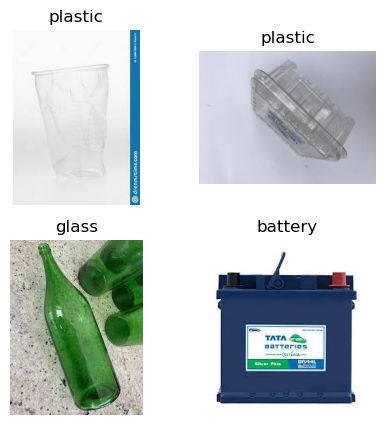

In [20]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [21]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Trash: 667
Plastic: 2013
Cardboard: 1864
Metal: 1494
Biological: 788
Shoes: 1581
Glass: 3272
Clothes: 4260
Paper: 2169
Battery: 756

Total number of train images: 18864


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [22]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [23]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3272, 1494, 2169, 2013, 1581, 667]

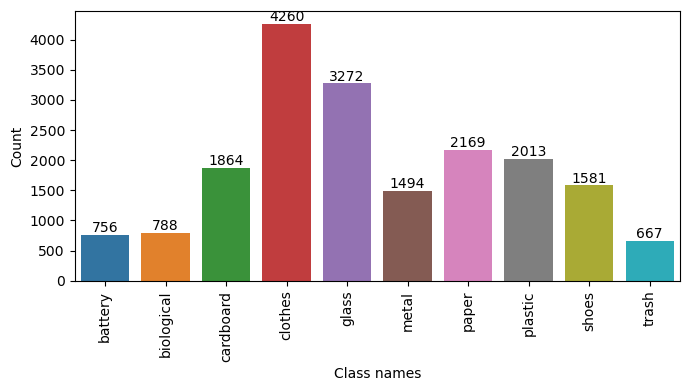

In [24]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (*random undersampling*), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [25]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 0 in trash
Deleted 1013 in plastic
Deleted 864 in cardboard
Deleted 494 in metal
Deleted 0 in biological
Deleted 581 in shoes
Deleted 2272 in glass
Deleted 3260 in clothes
Deleted 1169 in paper
Deleted 0 in battery


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [26]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

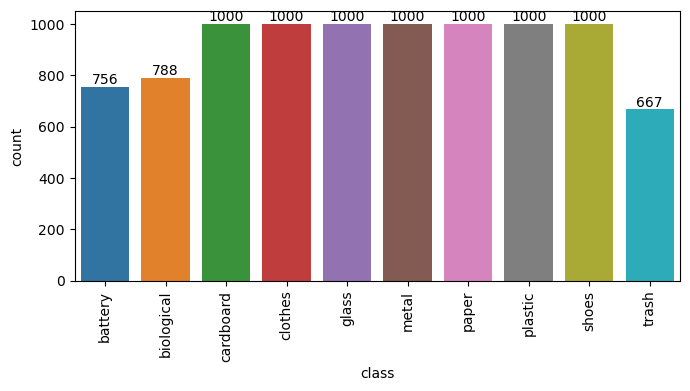

In [27]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [28]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [29]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 415.9736
Mean Height: 395.4559


Let's set the size of the input data (image size) taking into account the found average values

In [30]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [31]:
BATCH_SIZE = 32

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [32]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


In [33]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2366 files belonging to 10 classes.


In [34]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2354 files belonging to 10 classes.


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2S model, which has 88 layers, was selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.


Loading the model

In [35]:
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

82420632/82420632 [==============================] - 0s 0us/step


Let's see what the architecture of the pretrained model looks like

In [36]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 400, 400, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 200, 200, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [37]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [38]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

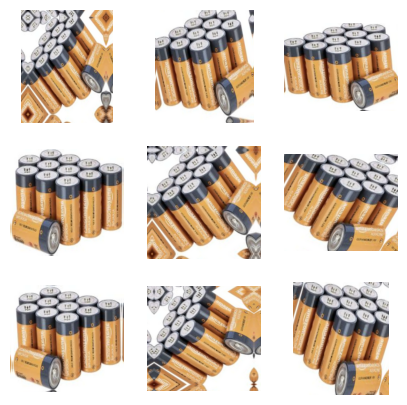

In [39]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [40]:
name="EfficientNetV2S"

EfficientNetV2S_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [41]:
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [42]:
EfficientNetV2S_model.summary()

Model: "EfficientNetV2S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, 13, 13, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                   

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [43]:
# Creating a Callback Function
def create_callback(model_name):
    
  # termination of training when accuracy does not improve within 3 epochs
  early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

  # decrease in learning rate when the error rate does not decrease over 2 epochs
  reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001) 

  # saving model
  check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
  
  callback = [early_stop, reduce_learning_rate, check_model]
  
  return callback

In [44]:
EfficientNetV2S_callback = create_callback(name)

Let's set the number of training epochs

In [45]:
EPOCH=20

Let's train the model

In [46]:
EfficientNetV2S_history = EfficientNetV2S_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2S_callback)

Epoch 1/20


2023-12-26 18:05:52.449727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 534s 2s/step - loss: 0.4570 - accuracy: 0.8604 - val_loss: 0.1781 - val_accuracy: 0.9405 - lr: 0.0010
Epoch 2/20
288/288 [==============================] - 452s 2s/step - loss: 0.2575 - accuracy: 0.9167 - val_loss: 0.1569 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 3/20
288/288 [==============================] - 420s 1s/step - loss: 0.2212 - accuracy: 0.9301 - val_loss: 0.1401 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 4/20
288/288 [==============================] - 391s 1s/step - loss: 0.1875 - accuracy: 0.9399 - val_loss: 0.1305 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 5/20
288/288 [==============================] - 368s 1s/step - loss: 0.1775 - accuracy: 0.9410 - val_loss: 0.1218 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 6/20
288/288 [==============================] - 347s 1s/step - loss: 0.1621 - accuracy: 0.9444 - val_loss: 0.1246 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 7/20
288/288 [==============================] - 339s 1s/step - loss: 

Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Let's look at the model training schedules.

In [47]:
EfficientNetV2S_model.save("/kaggle/working/garbage-classification.h5")

In [48]:
EfficientNetV2S_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [49]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

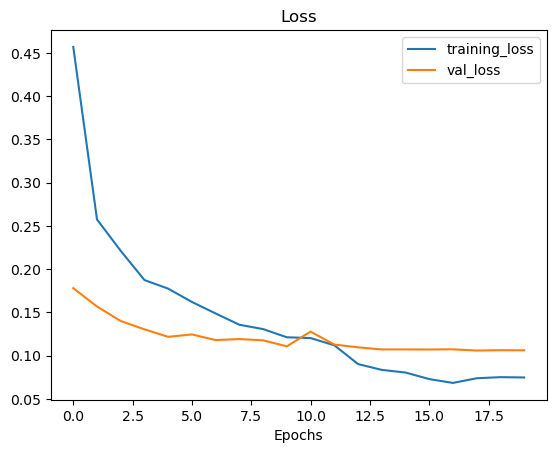

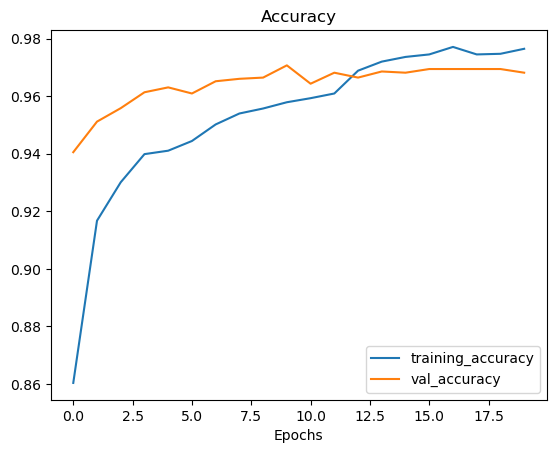

In [50]:
plot_loss_curves(EfficientNetV2S_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [51]:
test_loss, test_accuracy = EfficientNetV2S_model.evaluate(test_data, verbose=0)

In [52]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.13836
Test Accuracy: 96.28%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [53]:
pred_probs = EfficientNetV2S_model.predict(test_data, verbose=1)

74/74 [==============================] - 30s 373ms/step


In [54]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [56]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       1.00      0.96      0.98        95
  biological       1.00      0.99      0.99        99
   cardboard       0.96      0.97      0.96       234
     clothes       1.00      0.99      0.99       533
       glass       0.96      0.93      0.95       409
       metal       0.92      0.98      0.95       188
       paper       0.97      0.93      0.95       272
     plastic       0.92      0.93      0.93       253
       shoes       0.97      0.99      0.98       199
       trash       0.85      0.98      0.91        84

    accuracy                           0.96      2366
   macro avg       0.96      0.97      0.96      2366
weighted avg       0.96      0.96      0.96      2366



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [57]:
import itertools

In [58]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

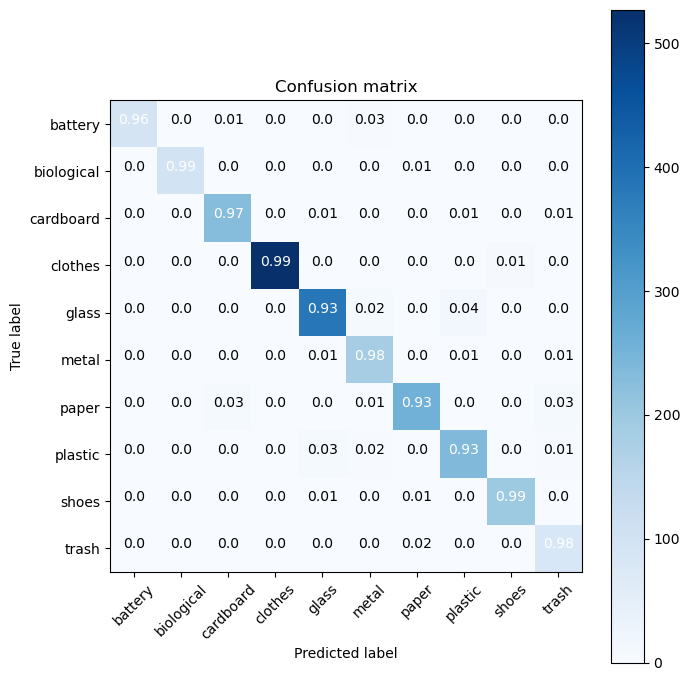

In [59]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [60]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0) 
        pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

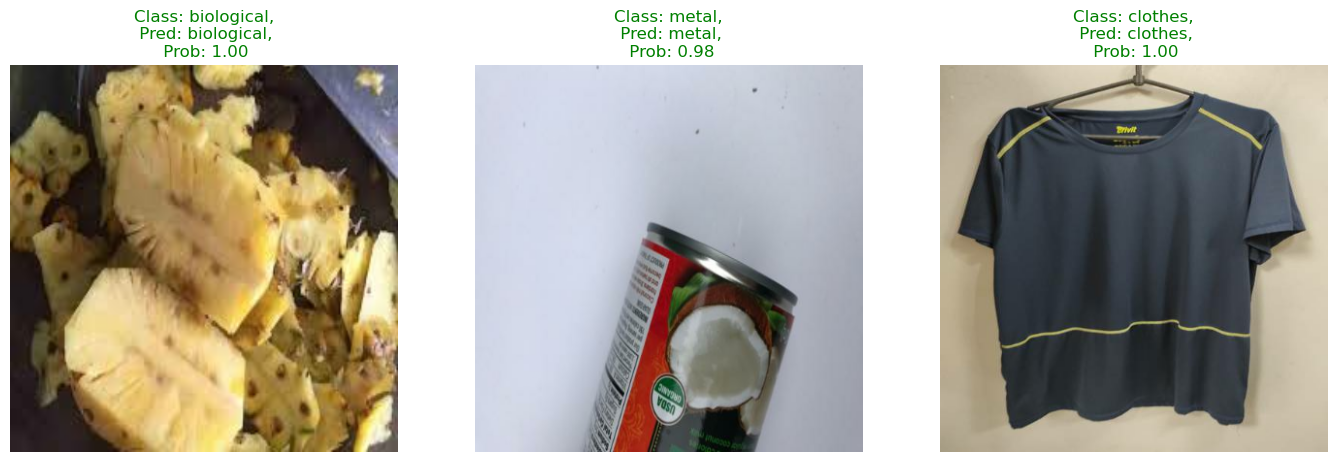

In [61]:
pred_random_images(EfficientNetV2S_model, test_path, class_names)

In [62]:
import pickle
pickle.dump(EfficientNetV2S_model,open("EfficientNetV2S_model.h5","wb"))
# EfficientNetV2S_model.save('EfficientNetV2S_model.h5')

In [63]:
ls ../working

EfficientNetV2S.h5        __notebook__.ipynb  garbage-classification.h5
EfficientNetV2S_model.h5  data/


Use Optuna for hyperparameter tunning. Here we are defining objective 

In [64]:
import optuna

In [65]:
def objective(trial):
    # hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    
    # Update the model with the suggested hyperparameters
    EfficientNetV2S_model = tf.keras.Sequential([
        tf.keras.Input(shape=(None, None, 3), name="input_layer"),
        data_augmentation,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),  # Use the suggested dropout_rate directly
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ], name=name)
    
    # Update the model with the suggested hyperparameters
    EfficientNetV2S_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    # Train the model with the updated hyperparameters
    history = EfficientNetV2S_model.fit(
        train_data,
        epochs=EPOCH,
        steps_per_epoch=len(train_data),
        validation_data=validation_data,
        validation_steps=len(validation_data),
        callbacks=EfficientNetV2S_callback
    )

    # Return the validation accuracy as the objective value to minimize
    return -history.history['val_accuracy'][-1]

In [66]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-12-26 19:54:00,039] A new study created in memory with name: no-name-304ba45d-995c-481e-9f48-7ba956941b7e
/tmp/ipykernel_26/3119378495.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/tmp/ipykernel_26/3119378495.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)


Epoch 1/20


2023-12-26 19:54:15.976105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 255s 833ms/step - loss: 0.4110 - accuracy: 0.8685 - val_loss: 0.1833 - val_accuracy: 0.9477 - lr: 0.0060
Epoch 2/20
288/288 [==============================] - 229s 795ms/step - loss: 0.2792 - accuracy: 0.9085 - val_loss: 0.1568 - val_accuracy: 0.9545 - lr: 0.0060
Epoch 3/20
288/288 [==============================] - 233s 809ms/step - loss: 0.2479 - accuracy: 0.9224 - val_loss: 0.1731 - val_accuracy: 0.9558 - lr: 0.0060
Epoch 4/20
288/288 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9281
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0011977105401456357.
288/288 [==============================] - 229s 794ms/step - loss: 0.2232 - accuracy: 0.9281 - val_loss: 0.2102 - val_accuracy: 0.9528 - lr: 0.0060
Epoch 5/20
288/288 [==============================] - 229s 793ms/step - loss: 0.1471 - accuracy: 0.9489 - val_loss: 0.1665 - val_accuracy: 0.9592 - lr: 0.0012
Epoch 5: early stopping


[I 2023-12-26 20:13:37,452] Trial 0 finished with value: -0.9592183232307434 and parameters: {'learning_rate': 0.00598855290286344, 'dropout_rate': 0.1075258471722011}. Best is trial 0 with value: -0.9592183232307434.


Epoch 1/20


2023-12-26 20:13:52.746316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 232s 756ms/step - loss: 0.5725 - accuracy: 0.8278 - val_loss: 0.2201 - val_accuracy: 0.9333 - lr: 7.1723e-04
Epoch 2/20
288/288 [==============================] - 225s 779ms/step - loss: 0.3179 - accuracy: 0.9037 - val_loss: 0.1683 - val_accuracy: 0.9477 - lr: 7.1723e-04
Epoch 3/20
288/288 [==============================] - 217s 754ms/step - loss: 0.2677 - accuracy: 0.9139 - val_loss: 0.1508 - val_accuracy: 0.9524 - lr: 7.1723e-04
Epoch 4/20
288/288 [==============================] - 214s 740ms/step - loss: 0.2443 - accuracy: 0.9229 - val_loss: 0.1501 - val_accuracy: 0.9516 - lr: 7.1723e-04
Epoch 5/20
288/288 [==============================] - 225s 778ms/step - loss: 0.2200 - accuracy: 0.9291 - val_loss: 0.1397 - val_accuracy: 0.9558 - lr: 7.1723e-04
Epoch 6/20
288/288 [==============================] - 203s 702ms/step - loss: 0.2114 - accuracy: 0.9296 - val_loss: 0.1293 - val_accuracy: 0.9596 - lr: 7.1723e-04
Epoch 7/20
288/288 [=============

[I 2023-12-26 21:21:47,259] Trial 1 finished with value: -0.9706881642341614 and parameters: {'learning_rate': 0.000717227519565225, 'dropout_rate': 0.4328086761437167}. Best is trial 1 with value: -0.9706881642341614.


Epoch 1/20


2023-12-26 21:22:03.273941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 213s 688ms/step - loss: 0.3867 - accuracy: 0.8742 - val_loss: 0.1935 - val_accuracy: 0.9401 - lr: 0.0047
Epoch 2/20
288/288 [==============================] - 187s 650ms/step - loss: 0.2522 - accuracy: 0.9184 - val_loss: 0.1625 - val_accuracy: 0.9511 - lr: 0.0047
Epoch 3/20
288/288 [==============================] - 189s 655ms/step - loss: 0.2040 - accuracy: 0.9329 - val_loss: 0.1612 - val_accuracy: 0.9537 - lr: 0.0047
Epoch 4/20
288/288 [==============================] - 176s 611ms/step - loss: 0.1774 - accuracy: 0.9413 - val_loss: 0.1457 - val_accuracy: 0.9635 - lr: 0.0047
Epoch 5/20
288/288 [==============================] - 188s 650ms/step - loss: 0.1756 - accuracy: 0.9440 - val_loss: 0.1549 - val_accuracy: 0.9609 - lr: 0.0047
Epoch 6/20
288/288 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9492
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009336177259683609.
288/288 [==============================] - 1

[I 2023-12-26 21:59:07,171] Trial 2 finished with value: -0.9736618399620056 and parameters: {'learning_rate': 0.004668088646978932, 'dropout_rate': 0.018116157277572487}. Best is trial 2 with value: -0.9736618399620056.


Epoch 1/20


2023-12-26 21:59:23.662176: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 194s 620ms/step - loss: 1.3935 - accuracy: 0.6297 - val_loss: 0.5987 - val_accuracy: 0.8980 - lr: 8.3256e-05
Epoch 2/20
288/288 [==============================] - 176s 610ms/step - loss: 0.6251 - accuracy: 0.8419 - val_loss: 0.3519 - val_accuracy: 0.9172 - lr: 8.3256e-05
Epoch 3/20
288/288 [==============================] - 173s 598ms/step - loss: 0.4807 - accuracy: 0.8632 - val_loss: 0.2812 - val_accuracy: 0.9265 - lr: 8.3256e-05
Epoch 4/20
288/288 [==============================] - 181s 626ms/step - loss: 0.4169 - accuracy: 0.8732 - val_loss: 0.2479 - val_accuracy: 0.9299 - lr: 8.3256e-05
Epoch 5/20
288/288 [==============================] - 175s 607ms/step - loss: 0.3841 - accuracy: 0.8821 - val_loss: 0.2286 - val_accuracy: 0.9346 - lr: 8.3256e-05
Epoch 6/20
288/288 [==============================] - 176s 610ms/step - loss: 0.3632 - accuracy: 0.8868 - val_loss: 0.2148 - val_accuracy: 0.9354 - lr: 8.3256e-05
Epoch 7/20
288/288 [=============

[I 2023-12-26 22:57:28,352] Trial 3 finished with value: -0.9549702405929565 and parameters: {'learning_rate': 8.325630783006315e-05, 'dropout_rate': 0.4054729858267029}. Best is trial 2 with value: -0.9736618399620056.


Epoch 1/20


2023-12-26 22:57:43.447499: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 186s 595ms/step - loss: 0.4606 - accuracy: 0.8590 - val_loss: 0.1872 - val_accuracy: 0.9397 - lr: 0.0018
Epoch 2/20
288/288 [==============================] - 166s 576ms/step - loss: 0.2793 - accuracy: 0.9054 - val_loss: 0.1615 - val_accuracy: 0.9477 - lr: 0.0018
Epoch 3/20
288/288 [==============================] - 169s 585ms/step - loss: 0.2513 - accuracy: 0.9159 - val_loss: 0.1456 - val_accuracy: 0.9554 - lr: 0.0018
Epoch 4/20
288/288 [==============================] - 168s 581ms/step - loss: 0.2261 - accuracy: 0.9235 - val_loss: 0.1493 - val_accuracy: 0.9550 - lr: 0.0018
Epoch 5/20
288/288 [==============================] - 168s 583ms/step - loss: 0.2083 - accuracy: 0.9302 - val_loss: 0.1422 - val_accuracy: 0.9601 - lr: 0.0018
Epoch 6/20
288/288 [==============================] - 167s 580ms/step - loss: 0.1916 - accuracy: 0.9363 - val_loss: 0.1291 - val_accuracy: 0.9652 - lr: 0.0018
Epoch 7/20
288/288 [==============================] - 163

[I 2023-12-26 23:53:11,274] Trial 4 finished with value: -0.969838559627533 and parameters: {'learning_rate': 0.0017863810761841394, 'dropout_rate': 0.37684811871916507}. Best is trial 2 with value: -0.9736618399620056.


Epoch 1/20


2023-12-26 23:53:27.629108: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 183s 580ms/step - loss: 0.4839 - accuracy: 0.8493 - val_loss: 0.1962 - val_accuracy: 0.9397 - lr: 0.0030
Epoch 2/20
288/288 [==============================] - 164s 568ms/step - loss: 0.3467 - accuracy: 0.8863 - val_loss: 0.1850 - val_accuracy: 0.9477 - lr: 0.0030
Epoch 3/20
288/288 [==============================] - 161s 557ms/step - loss: 0.3126 - accuracy: 0.8949 - val_loss: 0.1598 - val_accuracy: 0.9520 - lr: 0.0030
Epoch 4/20
288/288 [==============================] - 165s 572ms/step - loss: 0.2833 - accuracy: 0.9083 - val_loss: 0.1510 - val_accuracy: 0.9605 - lr: 0.0030
Epoch 5/20
288/288 [==============================] - 164s 569ms/step - loss: 0.2808 - accuracy: 0.9083 - val_loss: 0.1533 - val_accuracy: 0.9558 - lr: 0.0030
Epoch 6/20
288/288 [==============================] - 169s 587ms/step - loss: 0.2632 - accuracy: 0.9114 - val_loss: 0.1506 - val_accuracy: 0.9579 - lr: 0.0030
Epoch 7/20
288/288 [==============================] - 165

[I 2023-12-27 00:48:01,894] Trial 5 finished with value: -0.9677145481109619 and parameters: {'learning_rate': 0.0030474366985707444, 'dropout_rate': 0.4942615196143799}. Best is trial 2 with value: -0.9736618399620056.


Epoch 1/20


2023-12-27 00:48:18.305721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 184s 583ms/step - loss: 0.4165 - accuracy: 0.8674 - val_loss: 0.1769 - val_accuracy: 0.9435 - lr: 0.0018
Epoch 2/20
288/288 [==============================] - 162s 563ms/step - loss: 0.2500 - accuracy: 0.9165 - val_loss: 0.1562 - val_accuracy: 0.9520 - lr: 0.0018
Epoch 3/20
288/288 [==============================] - 158s 547ms/step - loss: 0.2196 - accuracy: 0.9273 - val_loss: 0.1369 - val_accuracy: 0.9579 - lr: 0.0018
Epoch 4/20
288/288 [==============================] - 163s 566ms/step - loss: 0.1955 - accuracy: 0.9358 - val_loss: 0.1365 - val_accuracy: 0.9592 - lr: 0.0018
Epoch 5/20
288/288 [==============================] - 164s 568ms/step - loss: 0.1843 - accuracy: 0.9357 - val_loss: 0.1339 - val_accuracy: 0.9584 - lr: 0.0018
Epoch 6/20
288/288 [==============================] - 161s 557ms/step - loss: 0.1720 - accuracy: 0.9434 - val_loss: 0.1328 - val_accuracy: 0.9664 - lr: 0.0018
Epoch 7/20
288/288 [==============================] - 165

[I 2023-12-27 01:42:16,588] Trial 6 finished with value: -0.9715378284454346 and parameters: {'learning_rate': 0.0018115930570399585, 'dropout_rate': 0.24311989496459385}. Best is trial 2 with value: -0.9736618399620056.


Epoch 1/20


2023-12-27 01:42:31.789755: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 179s 569ms/step - loss: 1.4735 - accuracy: 0.6165 - val_loss: 0.7037 - val_accuracy: 0.8904 - lr: 6.5070e-05
Epoch 2/20
288/288 [==============================] - 161s 559ms/step - loss: 0.6388 - accuracy: 0.8483 - val_loss: 0.4011 - val_accuracy: 0.9163 - lr: 6.5070e-05
Epoch 3/20
288/288 [==============================] - 162s 561ms/step - loss: 0.4678 - accuracy: 0.8747 - val_loss: 0.3127 - val_accuracy: 0.9248 - lr: 6.5070e-05
Epoch 4/20
288/288 [==============================] - 160s 554ms/step - loss: 0.4029 - accuracy: 0.8847 - val_loss: 0.2697 - val_accuracy: 0.9282 - lr: 6.5070e-05
Epoch 5/20
288/288 [==============================] - 162s 563ms/step - loss: 0.3631 - accuracy: 0.8928 - val_loss: 0.2446 - val_accuracy: 0.9312 - lr: 6.5070e-05
Epoch 6/20
288/288 [==============================] - 158s 549ms/step - loss: 0.3364 - accuracy: 0.8982 - val_loss: 0.2270 - val_accuracy: 0.9333 - lr: 6.5070e-05
Epoch 7/20
288/288 [=============

[I 2023-12-27 02:35:45,086] Trial 7 finished with value: -0.9541206359863281 and parameters: {'learning_rate': 6.507017831131432e-05, 'dropout_rate': 0.20653891092102578}. Best is trial 2 with value: -0.9736618399620056.


Epoch 1/20


2023-12-27 02:36:01.831271: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 178s 560ms/step - loss: 1.3915 - accuracy: 0.7377 - val_loss: 1.6526 - val_accuracy: 0.8522 - lr: 0.0539
Epoch 2/20
288/288 [==============================] - 160s 554ms/step - loss: 1.4480 - accuracy: 0.7275 - val_loss: 1.9661 - val_accuracy: 0.8662 - lr: 0.0539
Epoch 3/20
288/288 [==============================] - ETA: 0s - loss: 1.6520 - accuracy: 0.7397
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.010776580870151521.
288/288 [==============================] - 161s 557ms/step - loss: 1.6520 - accuracy: 0.7397 - val_loss: 1.7124 - val_accuracy: 0.8704 - lr: 0.0539
Epoch 4/20
288/288 [==============================] - 159s 550ms/step - loss: 1.1868 - accuracy: 0.7557 - val_loss: 1.1137 - val_accuracy: 0.8925 - lr: 0.0108
Epoch 5/20
288/288 [==============================] - 160s 553ms/step - loss: 0.8547 - accuracy: 0.7867 - val_loss: 0.9103 - val_accuracy: 0.9163 - lr: 0.0108
Epoch 6/20
288/288 [==============================] - 15

[I 2023-12-27 03:29:04,890] Trial 8 finished with value: -0.9430755972862244 and parameters: {'learning_rate': 0.053882905919785305, 'dropout_rate': 0.10831148743982066}. Best is trial 2 with value: -0.9736618399620056.


Epoch 1/20


2023-12-27 03:29:20.133044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 175s 558ms/step - loss: 2.4972 - accuracy: 0.6196 - val_loss: 3.1188 - val_accuracy: 0.7872 - lr: 0.0702
Epoch 2/20
288/288 [==============================] - 160s 554ms/step - loss: 2.6216 - accuracy: 0.5484 - val_loss: 2.5852 - val_accuracy: 0.7744 - lr: 0.0702
Epoch 3/20
288/288 [==============================] - 156s 541ms/step - loss: 2.9335 - accuracy: 0.5281 - val_loss: 3.7892 - val_accuracy: 0.7574 - lr: 0.0702
Epoch 4/20
288/288 [==============================] - ETA: 0s - loss: 2.9440 - accuracy: 0.4898
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.014048902690410614.
288/288 [==============================] - 160s 556ms/step - loss: 2.9440 - accuracy: 0.4898 - val_loss: 3.4182 - val_accuracy: 0.6810 - lr: 0.0702
Epoch 5/20
288/288 [==============================] - 157s 545ms/step - loss: 1.9806 - accuracy: 0.4637 - val_loss: 2.8350 - val_accuracy: 0.6937 - lr: 0.0140
Epoch 5: early stopping


[I 2023-12-27 03:42:35,909] Trial 9 finished with value: -0.6937128305435181 and parameters: {'learning_rate': 0.07024451200482434, 'dropout_rate': 0.4252599567769044}. Best is trial 2 with value: -0.9736618399620056.


Best Hyperparameters: {'learning_rate': 0.004668088646978932, 'dropout_rate': 0.018116157277572487}


In [67]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [68]:
# Create the final model with the best hyperparameters
final_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None, None, 3), name="input_layer"),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(best_params['dropout_rate']),  # Use the best dropout_rate
    tf.keras.layers.Dense(len(class_names), activation='softmax')
], name=name)

In [69]:
# Update the model with the best hyperparameters
final_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    metrics=['accuracy']
)

In [70]:
# Train the model with the entire dataset or a larger portion if needed
final_epochs = 20  # same epochs for consistency
final_history = final_model.fit(
    train_data,
    epochs=final_epochs,
    steps_per_epoch=len(train_data),
    callbacks=EfficientNetV2S_callback
)

Epoch 1/20


2023-12-27 03:43:33.023766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetV2S/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


288/288 [==============================] - 147s 451ms/step - loss: 0.3821 - accuracy: 0.8797 - lr: 0.0047
Epoch 2/20
288/288 [==============================] - 128s 444ms/step - loss: 0.2520 - accuracy: 0.9174 - lr: 0.0047
Epoch 3/20
288/288 [==============================] - 130s 450ms/step - loss: 0.2020 - accuracy: 0.9313 - lr: 0.0047
Epoch 4/20
288/288 [==============================] - 130s 451ms/step - loss: 0.1825 - accuracy: 0.9405 - lr: 0.0047
Epoch 5/20
288/288 [==============================] - 130s 449ms/step - loss: 0.1740 - accuracy: 0.9437 - lr: 0.0047
Epoch 6/20
288/288 [==============================] - 131s 455ms/step - loss: 0.1501 - accuracy: 0.9502 - lr: 0.0047
Epoch 7/20
288/288 [==============================] - 129s 447ms/step - loss: 0.1452 - accuracy: 0.9508 - lr: 0.0047
Epoch 8/20
288/288 [==============================] - 127s 441ms/step - loss: 0.1401 - accuracy: 0.9558 - lr: 0.0047
Epoch 9/20
288/288 [==============================] - 130s 449ms/step - los

In [71]:
test_loss, test_accuracy = final_model.evaluate(test_data, verbose=0)

In [72]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.20722
Test Accuracy: 96.41%


In [73]:
#save the result
pickle.dump(final_model,open("EfficientNetV2S_model_optimized.h5","wb"))